In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os

/home/hailey/anaconda3/envs/env_for_notebook/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hailey/anaconda3/envs/env_for_notebook/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hailey/anaconda3/envs/env_for_notebook/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hailey/ana

### Load the data

In [2]:
vols = sio.loadmat('./sensorimotor_4D_sample.mat')

In [3]:
X_train, X_test, y_train, y_test = vols['X_train'], vols['X_test'], vols['y_train'], vols['y_test']
n_classes = 4

In [4]:
print(np.shape(X_train),np.shape(X_test),np.shape(y_train),np.shape(y_test))

(1320, 53, 63, 46) (120, 53, 63, 46) (1320, 1) (120, 1)


In [5]:
y_train

array([[1],
       [2],
       [0],
       ...,
       [3],
       [2],
       [3]], dtype=uint8)

### z-scoring to normalize the data

In [6]:
x_mean = np.mean(X_train)
x_std = np.std(X_train)

In [7]:
X_tr_centered = (X_train - x_mean)/x_std
X_ts_centered = (X_test - x_mean)/x_std

### 1D array for labels

In [8]:
y_train = y_train.flatten()
y_test = y_test.flatten()

#### Checking out the dimension

In [9]:
X_tr_centered.shape,  X_ts_centered.shape

((1320, 53, 63, 46), (120, 53, 63, 46))

In [10]:
np.std(X_ts_centered)

1.0094781412712692

#### Checking out the image 

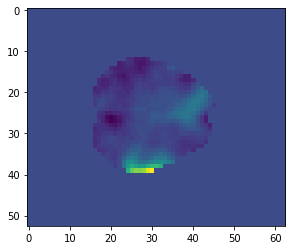

In [11]:
plt.imshow(X_tr_centered[1,:,:,40])
plt.show()

### Batch generator: to generate mini-batches for training 

In [12]:
def batch_generator(X, y, batch_size=50, 
                    shuffle=True, random_seed=None):
    
    idx = np.arange(y.shape[0])
    
    if shuffle:
        rng = np.random.RandomState(random_seed)
        rng.shuffle(idx)
        X = X[idx]
        y = y[idx]
    
    for i in range(0, X.shape[0], batch_size):
        yield (X[i:i+batch_size, :], y[i:i+batch_size])

### 3D-CNN class

In [13]:
class Conv3dNN(object):
    def __init__(self, n_classes=4, batchsize=50,
                 epochs=100, learning_rate=1e-4, 
                 dropout_rate=0.5,
                 shuffle=True, random_seed=None):
        np.random.seed(random_seed)
        self.batchsize = batchsize
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.shuffle = shuffle
        self.n_classes = n_classes
                
        g = tf.Graph()
        with g.as_default():
            ## set random-seed:
            tf.set_random_seed(random_seed)
            
            ## build the network:
            self.build()

            ## initializer
            self.init_op = \
                tf.global_variables_initializer()

            ## saver
            self.saver = tf.train.Saver()
            
        ## create a session
        self.sess = tf.Session(graph=g)
                
    def build(self):
        
        ## Placeholders for X and y:
        tf_x = tf.placeholder(tf.float32, 
                              shape=[None, 53, 63, 46],
                              name='tf_x')
        tf_y = tf.placeholder(tf.int32, 
                              shape=[None],
                              name='tf_y')
        is_train = tf.placeholder(tf.bool, 
                              shape=(),
                              name='is_train')
        
        ## reshape x to 5D tensor:
        ## [batchsize, x, y, z, 1]
        tf_x_vol = tf.reshape(tf_x, shape=[-1, 53, 63, 46, 1],
                             name='input_x_3d_volumes')

        ## One-hot encoding:
        tf_y_onehot = tf.one_hot(indices=tf_y, depth=4,
                              dtype=tf.float32,
                              name='input_y_onehot')

        ## 1st layer: Conv_1
        h1 = tf.layers.conv3d(tf_x_vol, 
                              filters=8, 
                              kernel_size=(7, 7, 7), 
                              strides=(1, 1, 1),
                              padding='valid',
                              activation=tf.nn.relu)
        ## MaxPooling
        h1_pool = tf.layers.max_pooling3d(h1, 
                              pool_size=(2, 2, 2), 
                              strides=(2, 2, 2))
        
        ## 2nd layer: Conv_2
        h2 = tf.layers.conv3d(h1_pool, 
                              filters=16, 
                              kernel_size=(5, 5, 5), 
                              strides=(1,1,1),
                              padding='valid',
                              activation=tf.nn.relu)
        ## MaxPooling 
        h2_pool = tf.layers.max_pooling3d(h2, 
                              pool_size=(2, 2, 2), 
                              strides=(2, 2, 2))

        ## 3rd layer: Conv_3
        h3 = tf.layers.conv3d(h2_pool, 
                              filters=32, 
                              kernel_size=(3, 3, 3), 
                              strides=(1,1,1),
                              padding='valid',
                              activation=tf.nn.relu)
        ## MaxPooling 
        h3_pool = tf.layers.max_pooling3d(h3, 
                              pool_size=(2, 2, 2), 
                              strides=(2, 2, 2))
        
        ## 4th layer: Fully Connected
        input_shape = h3_pool.get_shape().as_list()
        n_input_units = np.prod(input_shape[1:])
        h3_pool_flat = tf.reshape(h3_pool, 
                              shape=[-1, n_input_units])
        
        h4 = tf.layers.dense(h3_pool_flat, 128, 
                              activation=tf.nn.relu)

        ## Dropout
        h4_drop = tf.layers.dropout(h4, 
                              rate=self.dropout_rate,
                              training=is_train)
        
        ## 5th layer: Fully Connected (linear activation)
        h5 = tf.layers.dense(h4_drop, self.n_classes, 
                              activation=tf.nn.sigmoid)

        ## Prediction
        predictions = {
            'probabilities': tf.nn.softmax(h5, 
                              name='probabilities'),
            'labels': tf.cast(tf.argmax(h5, axis=1), 
                              tf.int32, name='labels')}
        
        ## Loss Function and Optimization
        cross_entropy_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=h5, labels=tf_y_onehot),
            name='cross_entropy_loss')
        
        ## Optimizer:
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        optimizer = optimizer.minimize(cross_entropy_loss,
                              name='train_op')

        ## Finding accuracy
        correct_predictions = tf.equal(
            predictions['labels'], 
            tf_y, name='correct_preds')
        
        accuracy = tf.reduce_mean(
            tf.cast(correct_predictions, tf.float32),
            name='accuracy')

    def save(self, epoch, path='./CNN3d-tflayers-model/'):
        if not os.path.isdir(path):
            os.makedirs(path)
        print('Saving model in %s' % path)
        self.saver.save(self.sess, 
                        os.path.join(path, 'model.ckpt'),
                        global_step=epoch)
        
    def load(self, epoch, path):
        print('Loading model from %s' % path)
        self.saver.restore(self.sess, 
             os.path.join(path, 'model.ckpt-%d' % epoch))
        
    def train(self, training_set, 
              validation_set=None,
              initialize=True):
        ## initialize variables
        if initialize:
            self.sess.run(self.init_op)

        self.train_cost_ = []
        X_data_tr = np.array(training_set[0])
        y_data_tr = np.array(training_set[1])

        for epoch in range(1, self.epochs + 1):
            batch_gen_tr = \
                batch_generator(X_data_tr, y_data_tr, batch_size=self.batchsize, 
                                 shuffle=self.shuffle)
            avg_loss = 0.0
            for i, (batch_x,batch_y) in \
                enumerate(batch_gen_tr):
                feed = {'tf_x:0': batch_x, 
                        'tf_y:0': batch_y,
                        'is_train:0': True} ## for dropout
                loss, _ = self.sess.run(
                        ['cross_entropy_loss:0', 'train_op'], 
                        feed_dict=feed)
                avg_loss += loss
                
            print('Epoch %02d: Training Avg. Loss: '
                  '%7.3f' % (epoch, avg_loss), end=' ')
            if validation_set is not None:
                
                X_data_ts = np.array(training_set[0])
                y_data_ts = np.array(training_set[1])
                # test accuracy
                batch_gen_ts = \
                batch_generator(X_data_ts, y_data_ts,
                                 shuffle=False,batch_size=self.batchsize)
                avg_valid_acc = 0.0
                for i, (batch_x,batch_y) in \
                    enumerate(batch_gen_ts):
                    feed = {'tf_x:0': batch_x,
                            'tf_y:0': batch_y,
                            'is_train:0': False} ## for dropout
                    avg_valid_acc = avg_valid_acc + self.sess.run('accuracy:0', feed_dict=feed)
                avg_valid_acc = avg_valid_acc/(i+1)
                
                print('Validation Acc: %7.3f' % avg_valid_acc)
            else:
                print()
                    
    def predict(self, X_test, return_proba = False):
        feed = {'tf_x:0': X_test,
                'is_train:0': False} ## for dropout
        if return_proba:
            return self.sess.run('probabilities:0',
                                 feed_dict=feed)
        else:
            return self.sess.run('labels:0',
                                 feed_dict=feed)

### Create an instance of the CNN3dNN class, train it, and save the trained model

In [14]:
cnn3d = Conv3dNN(random_seed=123, epochs=50, n_classes=n_classes)

cnn3d.train(training_set=(X_tr_centered, y_train), 
         validation_set=(X_ts_centered, y_test))

cnn3d.save(epoch=50)

Epoch 01: Training Avg. Loss:  36.404 Validation Acc:   0.609
Epoch 02: Training Avg. Loss:  31.540 Validation Acc:   0.856
Epoch 03: Training Avg. Loss:  26.874 Validation Acc:   0.914
Epoch 04: Training Avg. Loss:  25.061 Validation Acc:   0.932
Epoch 05: Training Avg. Loss:  23.826 Validation Acc:   0.950
Epoch 06: Training Avg. Loss:  23.189 Validation Acc:   0.949
Epoch 07: Training Avg. Loss:  22.600 Validation Acc:   0.961
Epoch 08: Training Avg. Loss:  22.299 Validation Acc:   0.967
Epoch 09: Training Avg. Loss:  22.072 Validation Acc:   0.970
Epoch 10: Training Avg. Loss:  21.772 Validation Acc:   0.972
Epoch 11: Training Avg. Loss:  21.623 Validation Acc:   0.972
Epoch 12: Training Avg. Loss:  21.513 Validation Acc:   0.979
Epoch 13: Training Avg. Loss:  21.484 Validation Acc:   0.981
Epoch 14: Training Avg. Loss:  21.349 Validation Acc:   0.981
Epoch 15: Training Avg. Loss:  21.248 Validation Acc:   0.979
Epoch 16: Training Avg. Loss:  21.229 Validation Acc:   0.984
Epoch 17

### To load the trained model and to test it using data 

In [17]:
del cnn3d

cnn3d_re = Conv3dNN(random_seed=123)
cnn3d_re.load(epoch=50, path='./CNN3d-tflayers-model/')

print(cnn3d_re.predict(X_ts_centered[:10,:,:,:]))


Loading model from ./CNN3d-tflayers-model/
INFO:tensorflow:Restoring parameters from ./CNN3d-tflayers-model/model.ckpt-50
[3 2 2 0 3 2 3 3 1 1]


### Accuray for all test data

In [18]:
preds = cnn3d_re.predict(X_ts_centered)

print('Test Accuracy: {:.2f}'.format( 100 * np.sum(y_test == preds)/len(y_test)))

Test Accuracy: 100.00
